### Import des librairies

In [ ]:
# basiques
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from imutils import paths

# deeplearning
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# lecture
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Création du modèle

In [59]:
# initialisation des paramètres du réseaux de neurones

INIT_LR = 1e-4  # learning rate initial = 0.0001
EPOCHS = 20     # nombre d'itérations du modèle 
BS = 32         # nombre de lot (utile pour la mémoire dans l'entrainement du modèle)

#### Travail sur les images

In [115]:
# liste des images classées par dossier "avec masque" et "sans masques"
imagePaths = list(paths.list_images(r"C:\Users\Bastien\OneDrive - Sportdatalab\Bureau\Scripts\projetBFK\dataset"))

In [116]:
# initialisation des listes pour les datas (images) et les labels (non des sous-dossier)
data = []
labels = []

# boucle pour récupérer les images
for imagePath in imagePaths:
	# j'extrais le lael de l'image via son sous-dossier classé
	label = imagePath.split(os.path.sep)[-2]

	# chargement de l'image et preprocessing en 224 x 224
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# j'assimile l'array ainsi que son label dans les deux listes
	data.append(image)
	labels.append(label)

In [117]:
# je convertis mes deux listes en numpy array pour le traitement des données
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [118]:
# j'encode mes labels "sans masque" = 0 et "avec masque" = 1
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

#### Modélisation du jeu de donnée

In [119]:
# split du jeu de donné en 80|20 car j'ai beaucoup d'image à disposition
x_train, x_test, y_train, y_test = train_test_split(
	data,              # image en narray
	labels,            # labels encodés
	test_size=0.20,    # test size
	stratify=labels,   # le label est la strate inférieur
	random_state=42    
	)

In [66]:
# construction d'un generateur d'image d'entrainement
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [67]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 0s 0us/step


In [68]:
# construction de la base du modèle et de ses hyperparamètres
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [69]:
# définition du modèle créé sur le modèle de base (cela deviendra notre modèle)
model = Model(inputs=baseModel.input, outputs=headModel)

In [70]:
# boucle pour figer la première mise à jour du modèle
for layer in baseModel.layers:
	layer.trainable = False

In [71]:
# compilation du modèle
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


C:\Users\Bastien\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### Entrainement du modèle

In [72]:
# entrainement du modèle
print("[INFO] training head...")
H = model.fit(
	aug.flow(x_train, y_train, batch_size=BS),
	steps_per_epoch=len(x_train) // BS,
	validation_data=(x_test, y_test),
	validation_steps=len(x_test) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
102/102 [==============================] - 154s 1s/step - loss: 0.3631 - accuracy: 0.8726 - val_loss: 0.1334 - val_accuracy: 0.9805
Epoch 2/20
102/102 [==============================] - 130s 1s/step - loss: 0.1353 - accuracy: 0.9673 - val_loss: 0.0803 - val_accuracy: 0.9853
Epoch 3/20
102/102 [==============================] - 130s 1s/step - loss: 0.0984 - accuracy: 0.9722 - val_loss: 0.0635 - val_accuracy: 0.9878
Epoch 4/20
102/102 [==============================] - 132s 1s/step - loss: 0.0775 - accuracy: 0.9778 - val_loss: 0.0590 - val_accuracy: 0.9866
Epoch 5/20
102/102 [==============================] - 139s 1s/step - loss: 0.0626 - accuracy: 0.9815 - val_loss: 0.0556 - val_accuracy: 0.9878
Epoch 6/20
102/102 [==============================] - 124s 1s/step - loss: 0.0597 - accuracy: 0.9824 - val_loss: 0.0504 - val_accuracy: 0.9878
Epoch 7/20
102/102 [==============================] - 125s 1s/step - loss: 0.0512 - accuracy: 0.9843 - val_loss: 0.048

In [120]:
# prédiction sur le jeu de donnée test
y_pred = model.predict(x_test, batch_size=BS)
# pour chaque prédiction, nous devons prendre le label corespondant
y_pred = np.argmax(y_pred, axis=1)

#### Evaluation du modèle

In [121]:
# evaluation du modele
print(classification_report(y_test.argmax(axis=1), y_pred,
	target_names=lb.classes_))

[INFO] evaluating network
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       433
without_mask       0.99      0.99      0.99       386

    accuracy                           0.99       819
   macro avg       0.99      0.99      0.99       819
weighted avg       0.99      0.99      0.99       819



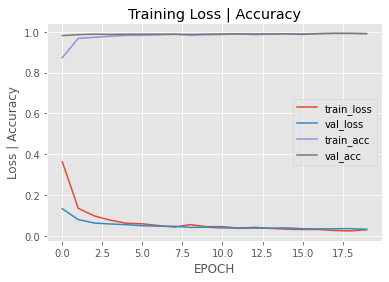

In [110]:
# graphique de la perte et de la précision sur les itérations du modèle
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss | Accuracy")
plt.xlabel("EPOCH")
plt.ylabel("Loss | Accuracy")
plt.legend(loc="center right")

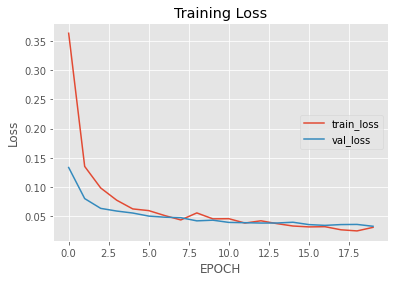

In [109]:
# graphique de la perte
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("EPOCH")
plt.ylabel("Loss")
plt.legend(loc="center right")

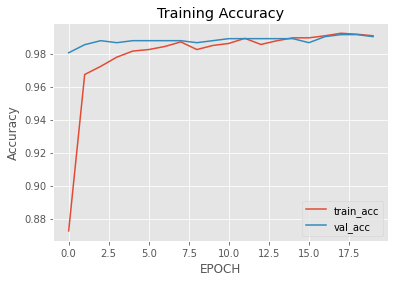

In [104]:
# graphique de la précision
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("EPOCH")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

### Prediction sur d'autres images personnelles

#### Structuration des images personnelles

In [92]:
# je charge 3 images perso (1 masquée + 2 non masquées)
perso = list(paths.list_images(r"C:\Users\Bastien\OneDrive - Sportdatalab\Bureau\Scripts\projetBFK\image_perso"))

In [93]:
data = []
labels = []

# boucle identique à precedemment
for imagePath in perso:
	label = imagePath.split(os.path.sep)[-2]

	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	data.append(image)
	labels.append(label)

In [94]:
# je convertis en array
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [95]:
# j'encode les labels des 3 photos
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

#### Prédictions

In [96]:
# predictions des images personnelles
predIdxs = model.predict(data, batch_size=BS)

# passage en array
predIdxs = np.argmax(predIdxs, axis=1)

In [97]:
# verification des predictions = ok
predIdxs

array([1, 0, 0], dtype=int64)

### Sauvegarde du reseaux de neurone

In [123]:
# sauvegarde du modèle
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...
